In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier as GDBSklearn
from xgboost import XGBClassifier


%matplotlib inline     

In [2]:
df=pd.read_csv('car_price_prediction.csv')

In [3]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


# Предобработка данных

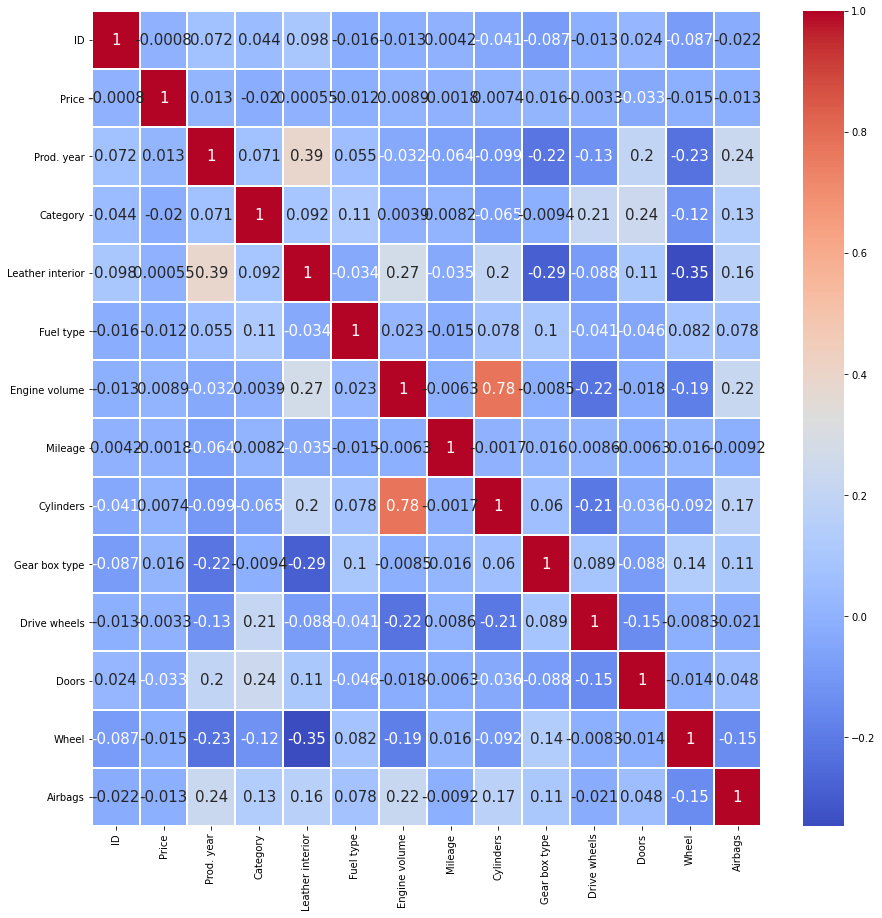

In [5]:
# удаление дубликатов
df=df.drop_duplicates()

#Преобразование категориальных признаков в числовые
le=LabelEncoder()
le.fit(df['Category'])
df['Category']=le.transform(df['Category'])

le=LabelEncoder()
le.fit(df['Leather interior'])
df['Leather interior']=le.transform(df['Leather interior'])

le=LabelEncoder()
le.fit(df['Fuel type'])
df['Fuel type']=le.transform(df['Fuel type'])

le=LabelEncoder()
le.fit(df['Gear box type'])
df['Gear box type']=le.transform(df['Gear box type'])

le=LabelEncoder()
le.fit(df['Drive wheels'])
df['Drive wheels']=le.transform(df['Drive wheels'])

le=LabelEncoder()
le.fit(df['Wheel'])
df['Wheel']=le.transform(df['Wheel'])

#выделение чисел в строковых данных
df['Mileage']=pd.to_numeric(df['Mileage'].str.split(' ',expand=True)[0])
df['Doors']=pd.to_numeric(df['Doors'].str.split('-',expand=True)[0].apply(lambda x:x[1]))
df['Engine volume']=pd.to_numeric(df['Engine volume'].str.split(' ',expand=True)[0])

#Матрица корриляции признаков
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cmap='coolwarm',annot=True,linewidths=1,annot_kws={'size': 15})

#get_dummies по производителю
df=pd.concat([df, pd.get_dummies(df.Manufacturer)], axis=1)
df=df.drop(columns=['ID','Levy','Model','Cylinders','Color','Manufacturer'])

#удаление выбросов по целевому признаку
q1=df.Price.quantile(0.25)
q3=df.Price.quantile(0.75)
df=df[(df.Price<(q3 + 1.5 * (q3-q1)))&((df.Price>(q1 - 1.5 * (q3-q1))))]

#удаление выбросов по пробегу автомобилей
q1=df.Mileage.quantile(0.25)
q3=df.Mileage.quantile(0.75)
df=df[(df.Mileage<(q3 + 1.5 * (q3-q1)))&((df.Mileage>(q1 - 1.5 * (q3-q1))))]

#Scaler на числовые признаки
num_cols = ['Prod. year','Engine volume','Mileage','Airbags']
StandardScaler().fit_transform(np.array(df[num_cols]))
df[num_cols]=StandardScaler().fit_transform(np.array(df[num_cols]))

#выделение цен больше 1000
df=df[df.Price>1000]

#Разделение категорий целевой переменной
df.Price=np.where(df.Price>=16000, 1, 0)

In [7]:
df.columns

Index(['Price', 'Prod. year', 'Category', 'Leather interior', 'Fuel type',
       'Engine volume', 'Mileage', 'Gear box type', 'Drive wheels', 'Doors',
       'Wheel', 'Airbags', 'ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI',
       'BENTLEY', 'BMW', 'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DAIHATSU', 'DODGE', 'FERRARI', 'FIAT', 'FORD',
       'GAZ', 'GMC', 'GREATWALL', 'HAVAL', 'HONDA', 'HUMMER', 'HYUNDAI',
       'INFINITI', 'ISUZU', 'JAGUAR', 'JEEP', 'KIA', 'LAMBORGHINI', 'LANCIA',
       'LAND ROVER', 'LEXUS', 'LINCOLN', 'MASERATI', 'MAZDA', 'MERCEDES-BENZ',
       'MERCURY', 'MINI', 'MITSUBISHI', 'MOSKVICH', 'NISSAN', 'OPEL',
       'PEUGEOT', 'PONTIAC', 'PORSCHE', 'RENAULT', 'ROLLS-ROYCE', 'ROVER',
       'SAAB', 'SATURN', 'SCION', 'SEAT', 'SKODA', 'SSANGYONG', 'SUBARU',
       'SUZUKI', 'TESLA', 'TOYOTA', 'UAZ', 'VAZ', 'VOLKSWAGEN', 'VOLVO', 'ZAZ',
       'სხვა'],
      dtype='object')

D:\Users\Ivan\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


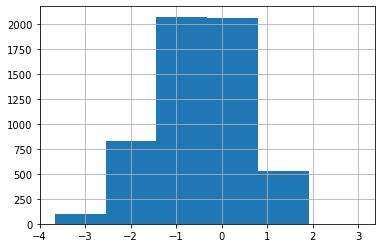

In [8]:
np.log(df['Engine volume']).hist(bins=6)

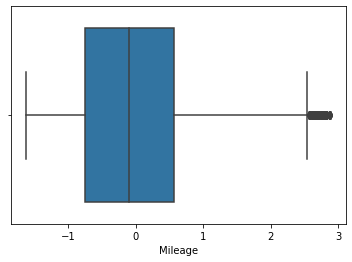

In [9]:
sns.boxplot(df.Mileage)

# Обучение моделей


In [10]:
#разделение признаков и целевой функции
Y=df.iloc()[:,0]
X=df.iloc()[:,1:]

## LogisticRegression

# LogisticRegression без GridSearch и CV

In [11]:
#разбиение учебной и обучающей выборки
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [96]:
#Обучение выборки
model = LogisticRegression()
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      2495
           1       0.67      0.68      0.68      1953

    accuracy                           0.71      4448
   macro avg       0.71      0.71      0.71      4448
weighted avg       0.71      0.71      0.71      4448


Confusion Matrix

[[1834  661]
 [ 618 1335]]


D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# LogisticRegression с GridSearch 

In [9]:
LR_params = {'penalty': ['l1','l2'],
            'C':[0.001, 0.01, 0.1, 1, 10, 100]}
model = LogisticRegression()
model = GridSearchCV(model,param_grid=LR_params,refit=True, cv=5)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))
print(model.best_params_)

D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\model_selection\_valida

D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_mo

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      2495
           1       0.67      0.68      0.68      1953

    accuracy                           0.71      4448
   macro avg       0.71      0.71      0.71      4448
weighted avg       0.71      0.71      0.71      4448


Confusion Matrix

[[1834  661]
 [ 618 1335]]
{'C': 1, 'penalty': 'l2'}


D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# LogisticRegression с CV

In [10]:
skf = StratifiedKFold(n_splits=5)
 
for train_index, test_index in skf.split(np.array(X), np.array(Y)):
    X_train,Y_train = X.iloc()[train_index], Y.iloc()[train_index]
    X_test, Y_test = X.iloc()[test_index], Y.iloc()[test_index]
    model = LogisticRegression(C=1, penalty='l2')
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print('accuracy = ',np.mean(y_pred == Y_test))

D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy =  0.7116357504215851


D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy =  0.7284991568296796


D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy =  0.7315345699831366


D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy =  0.7082630691399663
accuracy =  0.7209851551956815


D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# LogisticRegression график точности от C

In [11]:
acces=[] 
x1=[0.001, 0.01, 0.1, 1, 10, 100]
for value in x1:
    model = LogisticRegression(C=value)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    acces.append(np.mean(y_pred==Y_test))


D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

(0.6, 1.0)

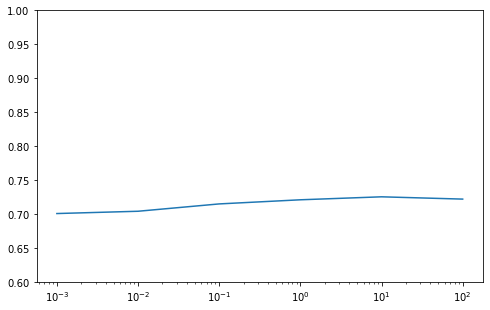

In [12]:
plt.figure(figsize=(8,5))
plt.plot(x1,acces)
plt.semilogx()
plt.ylim([0.6, 1])

## KNN

# KNN без GridSearch и CV

In [13]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1653
           1       0.80      0.81      0.81      1311

    accuracy                           0.83      2964
   macro avg       0.83      0.83      0.83      2964
weighted avg       0.83      0.83      0.83      2964


Confusion Matrix

[[1387  266]
 [ 244 1067]]


# KNN с GridSearch

In [14]:
KNN_params = {'n_neighbors': [2,4,6,8,10]}
model = KNeighborsClassifier()
model = GridSearchCV(model,param_grid=KNN_params,refit=True)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))
print(model.best_params_)

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1653
           1       0.83      0.77      0.80      1311

    accuracy                           0.83      2964
   macro avg       0.83      0.82      0.82      2964
weighted avg       0.83      0.83      0.82      2964


Confusion Matrix

[[1443  210]
 [ 307 1004]]
{'n_neighbors': 8}


# KNN с CV

In [15]:
skf = StratifiedKFold(n_splits=5)
 
for train_index, test_index in skf.split(np.array(X), np.array(Y)):
    X_train,Y_train = X.iloc()[train_index], Y.iloc()[train_index]
    X_test, Y_test = X.iloc()[test_index], Y.iloc()[test_index]
    model = KNeighborsClassifier(n_neighbors=6)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print('accuracy = ',np.mean(y_pred == Y_test))

accuracy =  0.8360876897133221
accuracy =  0.8462057335581787
accuracy =  0.8387858347386172
accuracy =  0.8232715008431704
accuracy =  0.8279352226720648


# KNN график точности от количество соседей

In [16]:
acces=[]
for values in KNN_params.values():
    x1=values
    for value in values:
        model = KNeighborsClassifier(n_neighbors=value)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        acces.append(np.mean(y_pred==Y_test))


(0.5, 1.0)

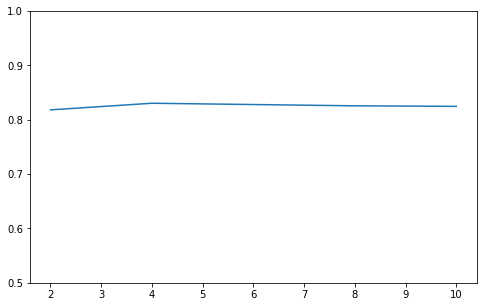

In [17]:
plt.figure(figsize=(8,5))
plt.plot(x1,acces)
plt.ylim([0.5, 1])

## SVM

# SVM без GridSearch и Кросс-валидации

In [18]:
model = svm.SVC()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1653
           1       0.76      0.73      0.74      1311

    accuracy                           0.78      2964
   macro avg       0.78      0.77      0.78      2964
weighted avg       0.78      0.78      0.78      2964


Confusion Matrix

[[1358  295]
 [ 358  953]]


# SVM c GridSearch

In [19]:
SVM_params = {"gamma": [0.001, 0.01, 0.1, 1]}
model = svm.SVC()
model = GridSearchCV(model,param_grid=SVM_params,refit=True)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))
print(model.best_params_)

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1653
           1       0.81      0.80      0.81      1311

    accuracy                           0.83      2964
   macro avg       0.83      0.83      0.83      2964
weighted avg       0.83      0.83      0.83      2964


Confusion Matrix

[[1411  242]
 [ 262 1049]]
{'gamma': 0.1}


# SVM c CV

In [20]:
skf = StratifiedKFold(n_splits=5)
 
for train_index, test_index in skf.split(np.array(X), np.array(Y)):
    X_train,Y_train = X.iloc()[train_index], Y.iloc()[train_index]
    X_test, Y_test = X.iloc()[test_index], Y.iloc()[test_index]
    model = svm.SVC(gamma=0.1)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print('accuracy = ',np.mean(y_pred == Y_test))

accuracy =  0.8313659359190556
accuracy =  0.8320404721753795
accuracy =  0.8397976391231029
accuracy =  0.8310286677908938
accuracy =  0.8299595141700404


# SVM график точности от гаммы

In [21]:
acces=[]
x1=[0.001, 0.01, 0.1, 1]
for value in x1:
    model = svm.SVC(gamma=value)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    acces.append(np.mean(y_pred==Y_test))


(0.5, 1.0)

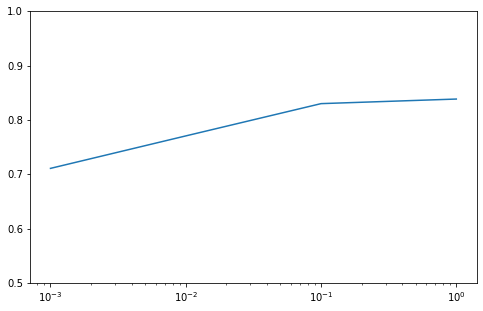

In [22]:
plt.figure(figsize=(8,5))
plt.plot(x1,acces)
plt.semilogx()
plt.ylim([0.5, 1])

# Naive Bayes


In [15]:
from collections import defaultdict

class NaiveBayesClassifier(object):
    def __init__(self):  
        self.class_freq = defaultdict(lambda:0)
        self.feat_freq = defaultdict(lambda:0)


    def fit(self, X, y):
        for feature, label in zip(X, y):
            self.class_freq[label] += 1
            for value in feature:
                self.feat_freq[(value, label)] += 1

        num_samples = len(X)
        for k in self.class_freq:
            self.class_freq[k] /= num_samples

        for value, label in self.feat_freq:
            self.feat_freq[(value, label)] /= self.class_freq[label]

        return self
    def predict(self, X):
        return min(self.class_freq.keys(), key=lambda c : self.calculate_class_freq(X, c)) 

    def calculate_class_freq(self, X, clss):
        freq = - np.log(self.class_freq[clss])

        for feat in X: 
            freq += - np.log(self.feat_freq.get((feat, clss), 10 ** (-7)))
        return freq

model = NaiveBayesClassifier().fit(X_train, Y_train)

y_pred = [model.predict(x) for x in np.array(X_test)]
print(accuracy_score(y_pred, Y_test))

0.5609262589928058


# Naive Bayes без GridSearch и Кросс-валидации

In [16]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.10      0.19      2495
           1       0.46      0.99      0.63      1953

    accuracy                           0.49      4448
   macro avg       0.69      0.55      0.41      4448
weighted avg       0.72      0.49      0.38      4448


Confusion Matrix

[[ 257 2238]
 [  23 1930]]


# Naive Bayes с GridSearch 

In [24]:
NB_params = {"var_smoothing": [0.01, 0.1, 1, 10, 100, 1000]}# расчет стабильности для расширения (или сглаживания) кривой 
model = GaussianNB()
model = GridSearchCV(model,param_grid=NB_params,refit=True)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))
print(model.best_params_)

              precision    recall  f1-score   support

           0       0.85      0.43      0.57      1653
           1       0.56      0.90      0.69      1311

    accuracy                           0.64      2964
   macro avg       0.70      0.67      0.63      2964
weighted avg       0.72      0.64      0.63      2964


Confusion Matrix

[[ 718  935]
 [ 130 1181]]
{'var_smoothing': 0.1}


# Naive Bayes с CV 

In [25]:
skf = StratifiedKFold(n_splits=5)
 
for train_index, test_index in skf.split(np.array(X), np.array(Y)):
    X_train,Y_train = X.iloc()[train_index], Y.iloc()[train_index]
    X_test, Y_test = X.iloc()[test_index], Y.iloc()[test_index]
    model = GaussianNB(var_smoothing=0.1)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print('accuracy = ',np.mean(y_pred == Y_test))

accuracy =  0.636424957841484
accuracy =  0.6458684654300169
accuracy =  0.6532883642495784
accuracy =  0.6192242833052276
accuracy =  0.6406882591093117


# Naive Bayes график точности от var_smothing

In [26]:
acces=[]
x1=[0.01,0.1, 1, 10, 100, 1000]
for value in x1:
    model = GaussianNB(var_smoothing=value)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    acces.append(np.mean(y_pred==Y_test))


(0.5, 1.0)

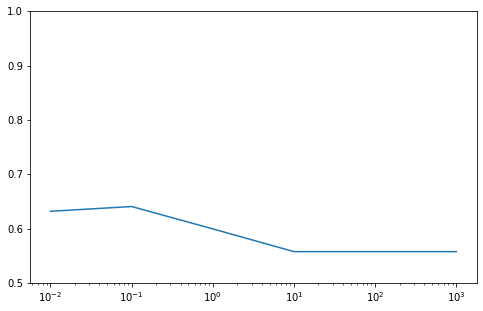

In [27]:
plt.figure(figsize=(8,5))
plt.plot(x1,acces)
plt.semilogx()
plt.ylim([0.5, 1])

## DecisionTree

# DecisionTree без GridSearch и CV

In [28]:
model = DecisionTreeClassifier(criterion="entropy", random_state=42,max_depth=7)   
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1653
           1       0.75      0.77      0.76      1311

    accuracy                           0.79      2964
   macro avg       0.79      0.79      0.79      2964
weighted avg       0.79      0.79      0.79      2964


Confusion Matrix

[[1323  330]
 [ 295 1016]]


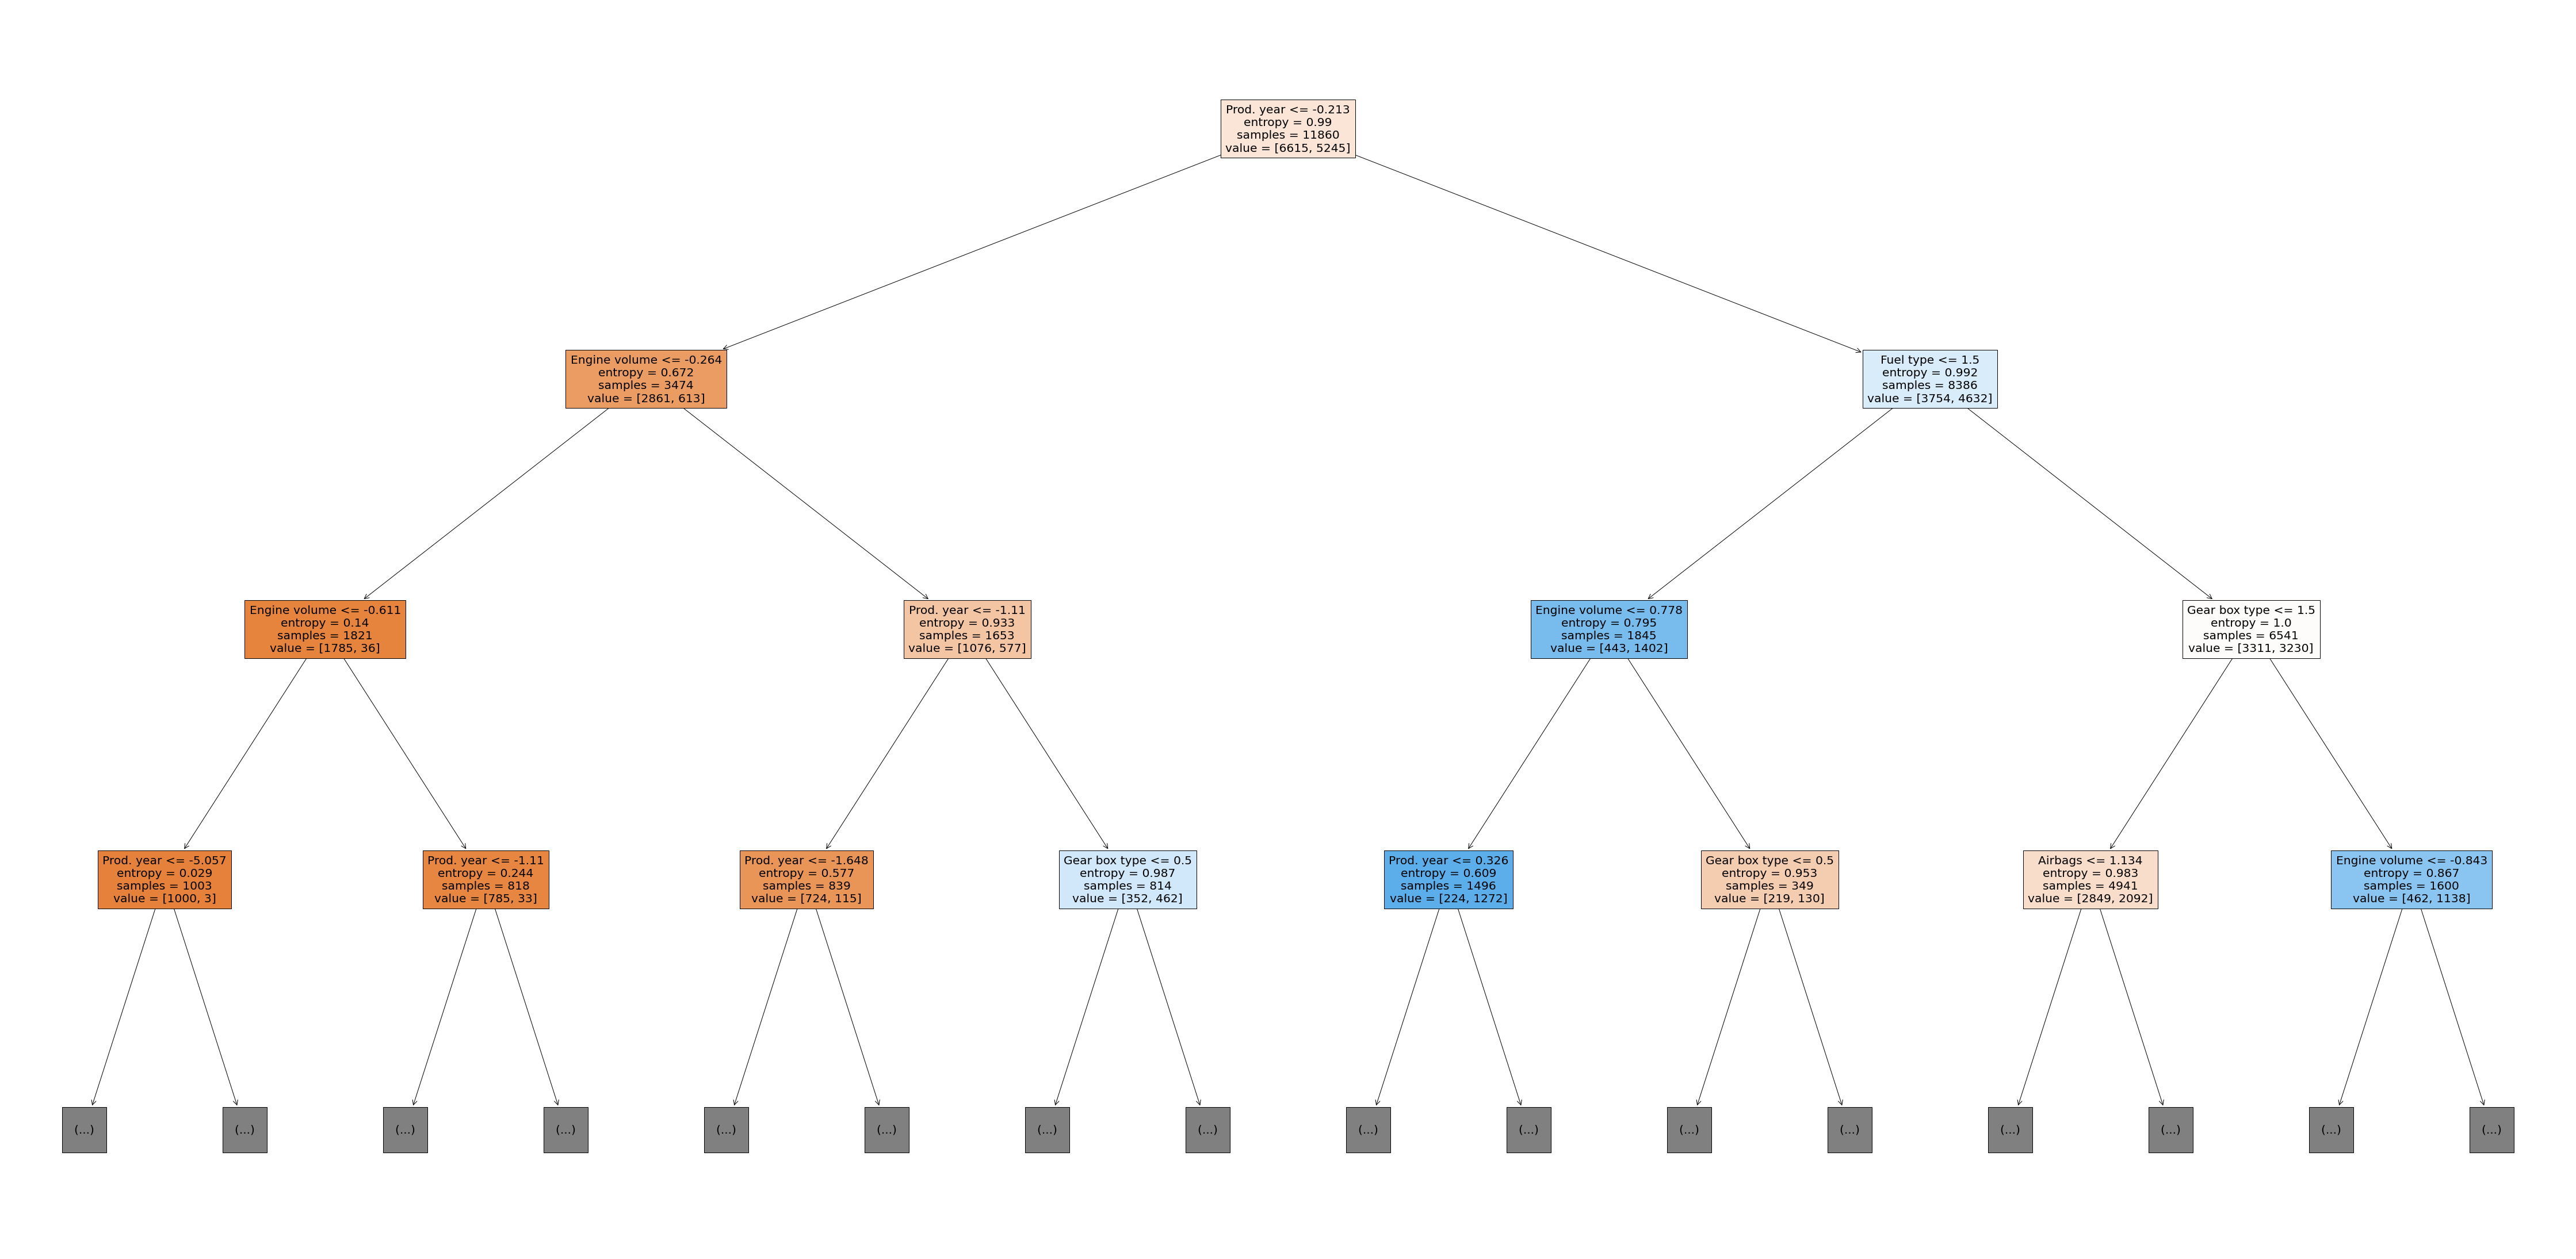

In [29]:
plt.figure(figsize =(80,40))
plot_tree(model, feature_names=X_train.columns, max_depth=3, filled=True);

# DecisionTree с GridSearch 

In [136]:
DT_params = {'criterion' : ['gini', 'entropy'], # функция для измерения качества разделения
            'max_depth' : [2,4,6,8,10], # глубина
            'max_leaf_nodes': [5,6,7], # максимальное количество листьев в дереве. 
            'min_samples_split': [2, 3, 4]} # Минимальное количество выборок, необходимое для разделения внутреннего узла
model = DecisionTreeClassifier()
model = GridSearchCV(model,param_grid=DT_params,refit=True)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))
print(model.best_params_)
print(classification_report(Y_train, model.predict(X_train)))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_train,model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1653
           1       0.73      0.55      0.62      1311

    accuracy                           0.71      2964
   macro avg       0.71      0.69      0.69      2964
weighted avg       0.71      0.71      0.70      2964


Confusion Matrix

[[1385  268]
 [ 595  716]]
{'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 7, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.70      0.84      0.77      6615
           1       0.73      0.55      0.63      5245

    accuracy                           0.71     11860
   macro avg       0.72      0.70      0.70     11860
weighted avg       0.72      0.71      0.70     11860


Confusion Matrix

[[5577 1038]
 [2373 2872]]


# Decision Tree c CV 

In [134]:
skf = StratifiedKFold(n_splits=5)
 
for train_index, test_index in skf.split(np.array(X), np.array(Y)):
    X_train,Y_train = X.iloc()[train_index], Y.iloc()[train_index]
    X_test, Y_test = X.iloc()[test_index], Y.iloc()[test_index]
    #model = DecisionTreeClassifier(criterion='entropy',max_depth=6, max_leaf_nodes= 7, min_samples_split= 2)
    model = DecisionTreeClassifier(criterion='gini',max_depth=10)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print('accuracy = ',np.mean(y_pred == Y_test))

accuracy =  0.8111298482293423
accuracy =  0.8145025295109612
accuracy =  0.8232715008431704
accuracy =  0.8185497470489039
accuracy =  0.8174763832658569


# Decision tree график точности от max_depth

In [32]:
acces=[]
x1=[2,4,6,8,10]
for value in x1:
    model = DecisionTreeClassifier(max_depth=value)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    acces.append(np.mean(y_pred==Y_test))


(0.5, 1.0)

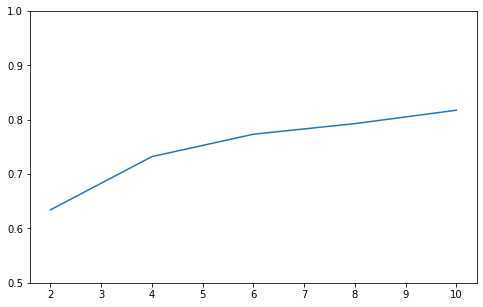

In [33]:
plt.figure(figsize=(8,5))
plt.plot(x1,acces)
plt.ylim([0.5, 1])




## Random Forest


# Random Forest без GridSearch и Кросс-валидации

In [64]:
model = RandomForestClassifier()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))

print(classification_report(Y_train,model.predict(X_train)))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_train,model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1653
           1       0.85      0.85      0.85      1311

    accuracy                           0.87      2964
   macro avg       0.87      0.87      0.87      2964
weighted avg       0.87      0.87      0.87      2964


Confusion Matrix

[[1454  199]
 [ 191 1120]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6615
           1       1.00      1.00      1.00      5245

    accuracy                           1.00     11860
   macro avg       1.00      1.00      1.00     11860
weighted avg       1.00      1.00      1.00     11860


Confusion Matrix

[[6601   14]
 [   7 5238]]


# Random Forest c GridSearch

In [84]:
RF_params = {'max_depth':[6,8,10],# глубина
             'n_estimators' : [512,1024],# количество деревьев в лесу
             'min_samples_leaf': [1, 2],# минимальное количество выборок, необходимых для нахождения в конечном узле
             'min_samples_split': [2, 5,10]}# минимальное количество выборок, необходимых для разделения внутреннего узла
model = RandomForestClassifier()
model = GridSearchCV(model,param_grid=RF_params,refit=True)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))
print(model.best_params_)

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1653
           1       0.82      0.76      0.79      1311

    accuracy                           0.82      2964
   macro avg       0.82      0.81      0.82      2964
weighted avg       0.82      0.82      0.82      2964


Confusion Matrix

[[1442  211]
 [ 318  993]]
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1024}


# Random Forest c CV

In [59]:
skf = StratifiedKFold(n_splits=5)
 
for train_index, test_index in skf.split(np.array(X), np.array(Y)):
    X_train,Y_train = X.iloc()[train_index], Y.iloc()[train_index]
    X_test, Y_test = X.iloc()[test_index], Y.iloc()[test_index]
    model = RandomForestClassifier(n_estimators=512,max_depth=8,min_samples_leaf=2,min_samples_split=2)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print('accuracy = ',np.mean(y_pred == Y_test))

accuracy =  0.8064080944350759
accuracy =  0.8016863406408095
accuracy =  0.8131534569983137
accuracy =  0.8016863406408095
accuracy =  0.8049932523616734


# Random Forest график точности от max_depth

In [49]:
acces=[]
x1=[2,4,6,8,10]
for value in x1:
    model = RandomForestClassifier(n_estimators=256,max_depth=value)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    acces.append(np.mean(y_pred==Y_test))


(0.5, 1.0)

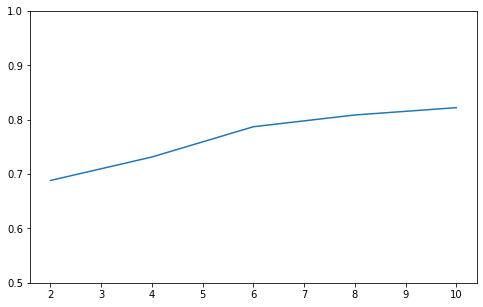

In [50]:
plt.figure(figsize=(8,5))
plt.plot(x1,acces)
plt.ylim([0.5, 1])

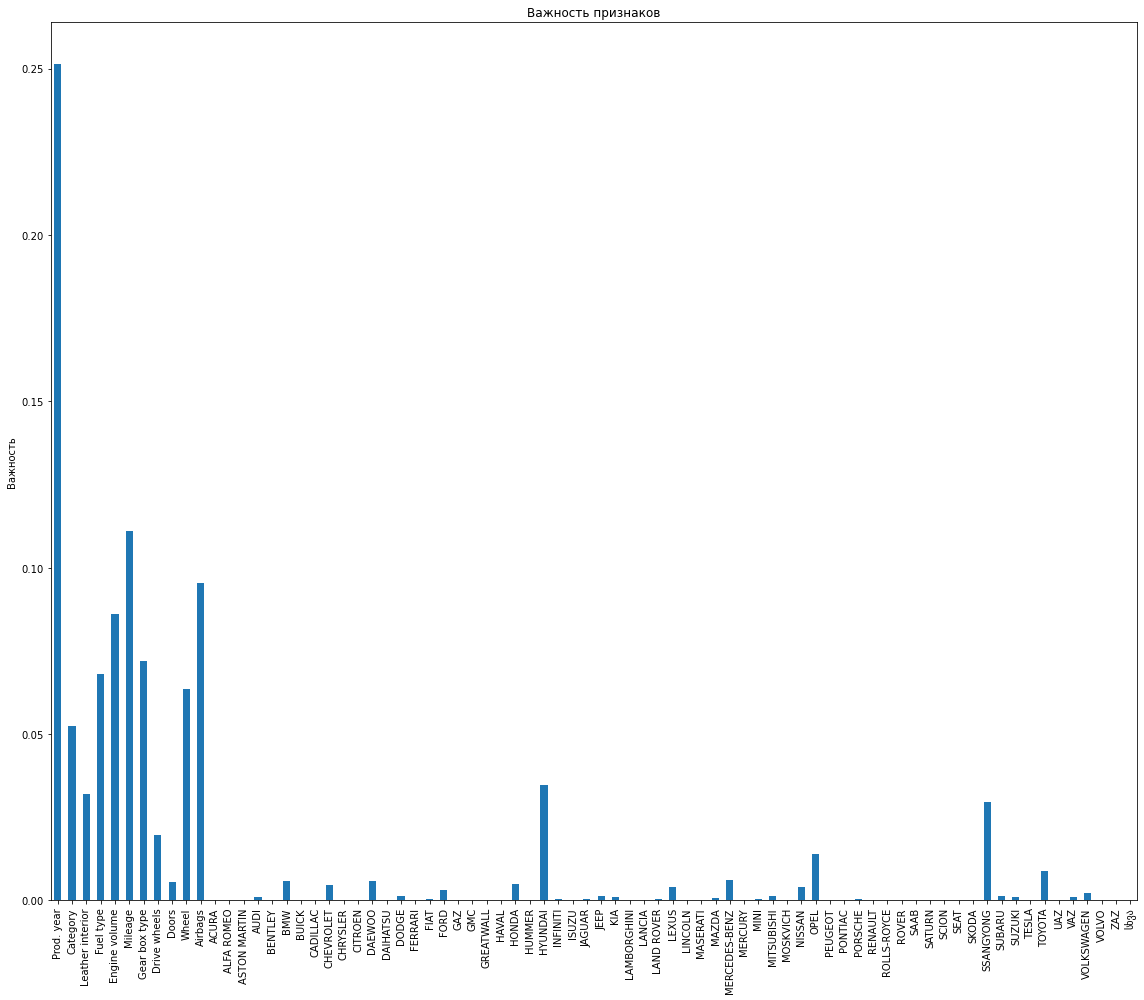

In [51]:
imp = pd.Series(model.feature_importances_,
                         df.drop(['Price'], axis=1).columns)

fig, ax = plt.subplots(figsize=(16,14))
imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

# Xgboost

# Xgboost без GridSearch и Кросс-валидации

In [39]:
model=XGBClassifier(seed=42)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1653
           1       0.85      0.86      0.85      1311

    accuracy                           0.87      2964
   macro avg       0.87      0.87      0.87      2964
weighted avg       0.87      0.87      0.87      2964


Confusion Matrix

[[1452  201]
 [ 185 1126]]


# Xgboost c GridSearch 

In [70]:
XB_params = {'max_depth':[2, 4, 6, 8, 10],
             'gamma':[ 0.0, 0.1, 0.2],#Минимальное сокращение потерь, необходимое для создания дополнительного раздела на конечном узле дерева.
             'num_parallel_tree':[1,2,3]}
model = XGBClassifier()
model = GridSearchCV(model,param_grid=XB_params,refit=True)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)

print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix\n")
print(confusion_matrix(Y_test,y_pred))
print(model.best_params_)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1653
           1       0.85      0.85      0.85      1311

    accuracy                           0.87      2964
   macro avg       0.87      0.87      0.87      2964
weighted avg       0.87      0.87      0.87      2964


Confusion Matrix

[[1460  193]
 [ 196 1115]]
{'gamma': 0.1, 'max_depth': 8, 'num_parallel_tree': 1}


# Xgboost c CV

In [71]:
skf = StratifiedKFold(n_splits=5)
 
for train_index, test_index in skf.split(np.array(X), np.array(Y)):
    X_train,Y_train = X.iloc()[train_index], Y.iloc()[train_index]
    X_test, Y_test = X.iloc()[test_index], Y.iloc()[test_index]
    model = XGBClassifier(gamma=0.1, max_depth = 8, num_parallel_tree=1)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print('accuracy = ',np.mean(y_pred == Y_test))

accuracy =  0.8593591905564925
accuracy =  0.8613827993254637
accuracy =  0.8704890387858347
accuracy =  0.8650927487352446
accuracy =  0.8687584345479082


# Xgboost график точности от max_depth

In [72]:
acces=[]
x1=[2,4,6,8,10]
for value in x1:
    model = XGBClassifier(num_parallel_tree=1,gamma=0.1,max_depth=value)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    acces.append(np.mean(y_pred==Y_test))


(0.5, 1.0)

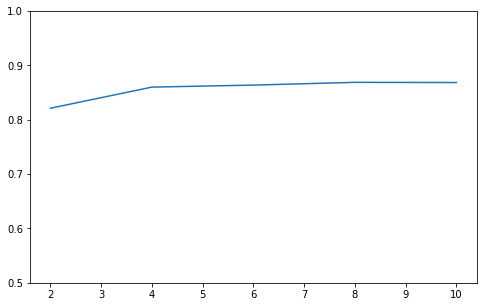

In [73]:
plt.figure(figsize=(8,5))
plt.plot(x1,acces)
plt.ylim([0.5, 1])

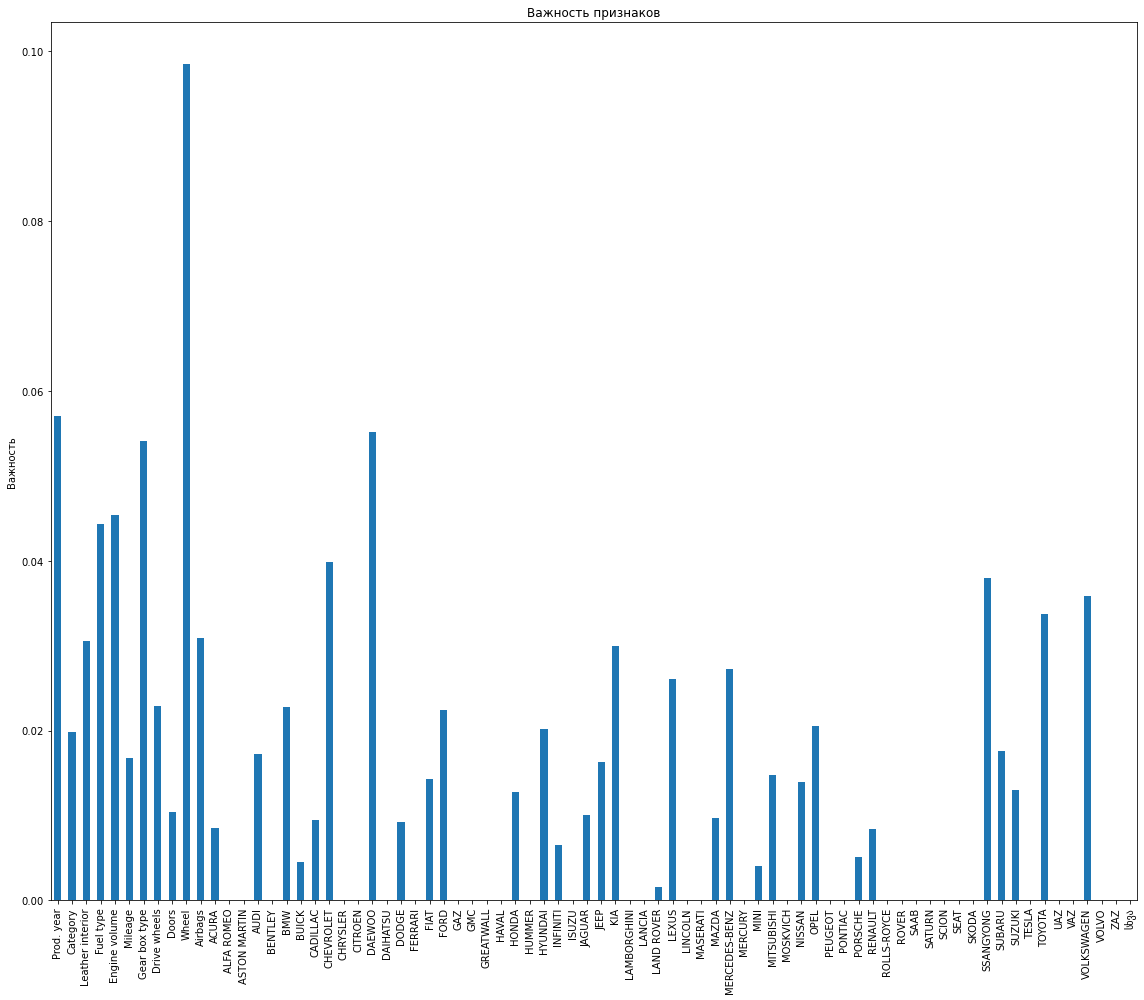

In [74]:
imp = pd.Series(model.feature_importances_,
                         df.drop(['Price'], axis=1).columns)

fig, ax = plt.subplots(figsize=(16,14))
imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()